# YOAGE APP POC

In [100]:
import numpy as np
import os
import shutil
import cv2
import matplotlib.pyplot as plt

# Preprocessing

In [53]:
from PoseClassification.bootstrap import BootstrapHelper

## Bootstrap Images

In [54]:
def copy_test_train_in_all():
    test_dir = os.path.join("assets", "images", "test")
    train_dir = os.path.join("assets", "images", "train")
    all_dir = os.path.join("assets", "images", "all")

    sources_dir = [test_dir, train_dir]

    for source_dir in sources_dir:
        for dir_ in os.listdir(source_dir):
            if "." not in dir_:  # check if it is a directory
                try:
                    os.mkdir(os.path.join(all_dir, dir_))
                except:
                    print(f"Directory - {dir_} - already exists")

                for file_ in os.listdir(os.path.join(source_dir, dir_)):
                    shutil.copy(
                        os.path.join(source_dir, dir_, file_),
                        os.path.join(all_dir, dir_, file_),
                    )


copy_test_train_in_all()

Directory - downdog - already exists
Directory - tree - already exists
Directory - warrior2 - already exists
Directory - goddess - already exists
Directory - plank - already exists
Directory - downdog - already exists
Directory - tree - already exists
Directory - warrior2 - already exists
Directory - goddess - already exists
Directory - plank - already exists


In [55]:
cwd = os.getcwd()

### Bootstrap Required Inputs

In [56]:
bootstrap_images_in_folder = os.path.join(cwd, "assets", "images", "all")
bootstrap_images_out_folder = os.path.join(cwd, "assets", "images", "bootstraped")
bootstrap_csvs_out_folder = os.path.join(cwd, "assets", "csv")

In [57]:
# Initialize helper.
bootstrap_helper = BootstrapHelper(
    images_in_folder=bootstrap_images_in_folder,
    images_out_folder=bootstrap_images_out_folder,
    csvs_out_folder=bootstrap_csvs_out_folder,
)

In [58]:
# Display Infos after __init__()
for _, el in enumerate(bootstrap_helper._pose_class_names):
    print(f"Class {_} - { el}")

Class 0 - downdog
Class 1 - goddess
Class 2 - plank
Class 3 - tree
Class 4 - warrior2


### Run Bootstrapo function

In [59]:
# Bootstrap the images.
run = input("Do you want to bootstrap the images? (y/n)")
if run == "y":
    bootstrap_helper.bootstrap(per_pose_class_limit=None)

### Removed the copy/paste images not in csvs

In [60]:
# Check how many pose classes and images for them are available.
print("Overall Images Bootstraped per Class:\n")
bootstrap_helper.print_images_in_statistics()
print("\nOnly Classified Images (no outliers):\n")
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Overall Images Bootstraped per Class:

Number of images per pose class:
  downdog: 320
  goddess: 260
  plank: 381
  tree: 229
  warrior2: 361

Only Classified Images (no outliers):

Number of images per pose class:
  downdog: 282
  goddess: 219
  plank: 358
  tree: 226
  warrior2: 332


In [61]:
print(" !!! At this stage you should have the same number of rows in the csv than images in folders")

 !!! At this stage you should have the same number of rows in the csv than images in folders


## Cleaning Before Classify

In [62]:
from PoseClassification.pose_classifier import PoseClassifier
from PoseClassification.pose_embedding import FullBodyPoseEmbedding
# from PoseClassification.utils import EMADictSmoothing
# from PoseClassification.visualize import PoseClassificationVisualizer

### Find outliers

In [63]:
# Find outliers.

# Transforms pose landmarks into embedding.
pose_embedder = FullBodyPoseEmbedding()

# Classifies give pose against database of poses.
pose_classifier = PoseClassifier(
    pose_samples_folder=bootstrap_csvs_out_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10,
)

outliers = pose_classifier.find_pose_sample_outliers()
print("Number of outliers: ", len(outliers))

Number of outliers:  18


### Show outliers

In [64]:
# Analyze outliers.
show = input("Do you want to analyze the outliers? (y/n)")
if show == "y":
    bootstrap_helper.analyze_outliers(outliers)

In [65]:
# Remove all outliers (if you don't want to manually pick).
try:
    bootstrap_helper.remove_outliers(outliers)
except:
    print("No outliers to remove. Already removed.")
# Align CSVs with images after removing outliers.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  downdog: 282
  goddess: 214
  plank: 357
  tree: 223
  warrior2: 323


# Classify

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score

### Prepare dataset

In [72]:
def build_header(num_embeddings):
    headers = (
        ["filename"]
        + [f"embedding_{i}" for i in range(1, num_embeddings + 1)]
        + ["class"]
    )
    return headers

In [90]:
num_to_class_dict = {
    0: "downdog",
    1: "goddess",
    2: "plank",
    3: "tree",
    4: "warrior2",
}

class_dict = {
    "downdog": 0,
    "goddess": 1,
    "plank": 2,
    "tree": 3,
    "warrior2": 4,
}

def build_dataframe(source_dir: str) -> pd.DataFrame:
    filenames = os.listdir(source_dir)
    headers = build_header(99)
    df = pd.DataFrame(columns=headers)
    for file_ in filenames:
        classname = file_.split(".")[0]
        filepath = os.path.join(source_dir, file_)
        df_temp = pd.read_csv(filepath, header=None)
        df_temp["class"] = classname
        df_temp.columns = headers
        df = pd.concat([df, df_temp], axis=0, ignore_index=True)

    df["class_num"] = df["class"].map(class_dict)
    return df

In [74]:
source_dir = os.path.join(cwd, "assets", "csv")
df = build_dataframe(source_dir=source_dir)
df["class_num"].value_counts()

/var/folders/vs/63szyqqn4dq91nzk275599p40000gn/T/ipykernel_25996/1124639866.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp], axis=0, ignore_index=True)


class_num
2    357
4    323
0    282
3    223
1    214
Name: count, dtype: int64

### Train / Test split

In [75]:
X = df.drop(
    ["filename", "class", "class_num"], axis=1
)  # Assuming 'label' is the column with class names/numbers
y = df["class_num"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [76]:
# Step 4: Normalize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the Classification Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# Step 6: Evaluate the Model
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# # Step 7: Predict on a New Image
# # Assuming `new_image_features` is a NumPy array of the features extracted from the new image
# new_image_features_scaled = scaler.transform([new_image_features])
# # prediction = clf.predict(new_image_features_scaled)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      0.86      0.93        37
           2       0.93      1.00      0.96        68
           3       0.98      0.93      0.95        43
           4       0.94      0.97      0.96        70

    accuracy                           0.96       280
   macro avg       0.97      0.95      0.96       280
weighted avg       0.97      0.96      0.96       280



# Pipeline

In [111]:
def print_image_from_filename(filename):
    dir_ = os.path.join(cwd, "assets", "images", "validation", "raw")

    for subdirs in os.listdir(dir_):
        if "." not in subdirs:
            for file_ in os.listdir(os.path.join(dir_, subdirs)):
                if file_ == filename:
                    filepath = os.path.join(dir_, subdirs, file_)
                    print(filepath)
                    image = cv2.imread(filepath)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    plt.imshow(image)
                    plt.show()

### Bootstrap

In [112]:
bootstrap_images_in_folder = os.path.join(cwd, "assets", "images", "validation", "raw")
bootstrap_images_out_folder = os.path.join(cwd, "assets", "images", "validation", "bootstrap")
bootstrap_csvs_out_folder = os.path.join(cwd, "assets",  "validation", "csv")

bootstrap_helper = BootstrapHelper(
    images_in_folder=bootstrap_images_in_folder,
    images_out_folder=bootstrap_images_out_folder,
    csvs_out_folder=bootstrap_csvs_out_folder,
)

In [113]:
bootstrap_helper.bootstrap(per_pose_class_limit=None)

Bootstrapping  downdog
100%|██████████| 3/3 [00:00<00:00,  3.72it/s]
Bootstrapping  goddess
100%|██████████| 5/5 [00:01<00:00,  3.87it/s]
Bootstrapping  plank
100%|██████████| 6/6 [00:01<00:00,  3.80it/s]
Bootstrapping  tree
100%|██████████| 2/2 [00:00<00:00,  3.82it/s]
Bootstrapping  warrior2
100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


In [114]:
source_dir = os.path.join(cwd, "assets", "validation", "csv")
df_val = build_dataframe(source_dir=source_dir)
df_val["class_num"].value_counts()

/var/folders/vs/63szyqqn4dq91nzk275599p40000gn/T/ipykernel_25996/3970672308.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp], axis=0, ignore_index=True)


class_num
2    6
1    5
0    3
4    2
3    2
Name: count, dtype: int64

In [115]:
from sklearn.metrics import classification_report, accuracy_score

# Prepare your validation data
# Features (make sure to drop any non-feature columns)
X_val = df_val.drop(["filename", "class", "class_num"], axis=1)
# Labels (assuming 'class_num' is the column with the correct class labels)
y_val = df_val["class_num"]
filename = df_val["filename"]

# Scale the features
scaler = StandardScaler()
X_val_scaled = scaler.fit_transform(X_val)

# Run predictions on the validation set features
y_pred = clf.predict(X_val_scaled)

# Evaluate the classifier
print(classification_report(y_val, y_pred))

# Compute accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.40      0.57         5
           2       1.00      0.67      0.80         6
           3       1.00      1.00      1.00         2
           4       0.40      1.00      0.57         2

    accuracy                           0.72        18
   macro avg       0.80      0.81      0.74        18
weighted avg       0.87      0.72      0.73        18

Accuracy: 72.22%


Predicted: 1 --> goddess
Actual: 2 --> plank
Filename: IMG_4882.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/plank/IMG_4882.JPG


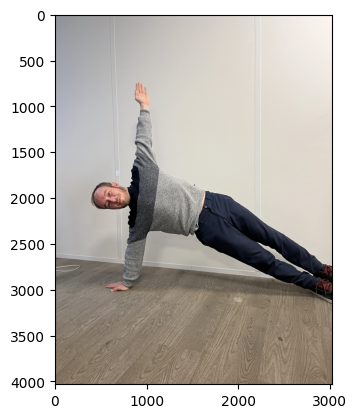



Predicted: 1 --> goddess
Actual: 2 --> plank
Filename: IMG_4883.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/plank/IMG_4883.JPG


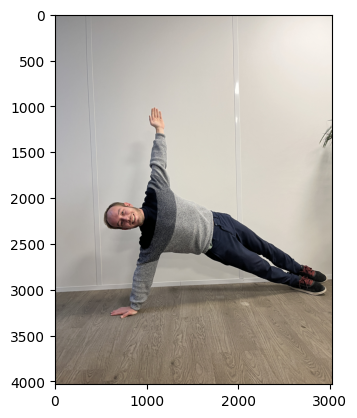



Predicted: 1 --> goddess
Actual: 2 --> plank
Filename: IMG_4884.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/plank/IMG_4884.JPG


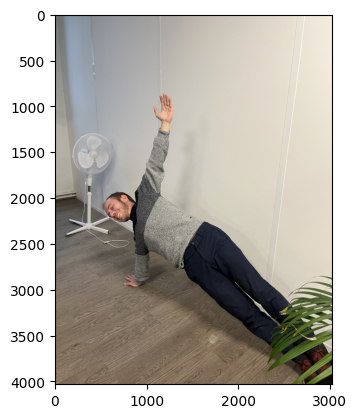



Predicted: 1 --> goddess
Actual: 2 --> plank
Filename: IMG_4885.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/plank/IMG_4885.JPG


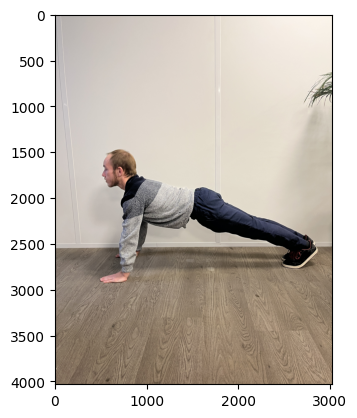



Predicted: 1 --> goddess
Actual: 2 --> plank
Filename: IMG_4886.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/plank/IMG_4886.JPG


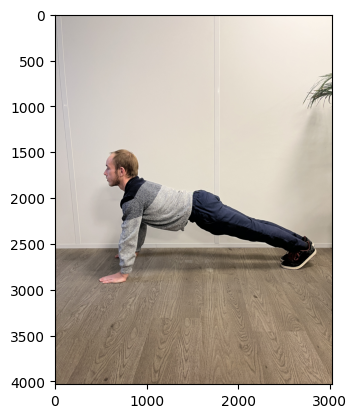



Predicted: 1 --> goddess
Actual: 2 --> plank
Filename: IMG_4887.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/plank/IMG_4887.JPG


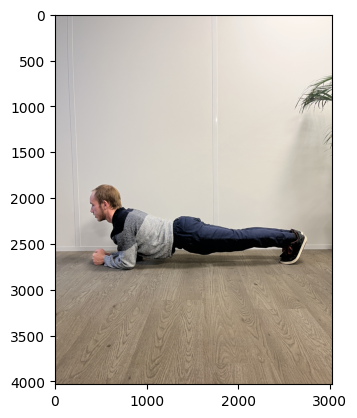



Predicted: 1 --> goddess
Actual: 4 --> warrior2
Filename: IMG_4890.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/warrior2/IMG_4890.JPG


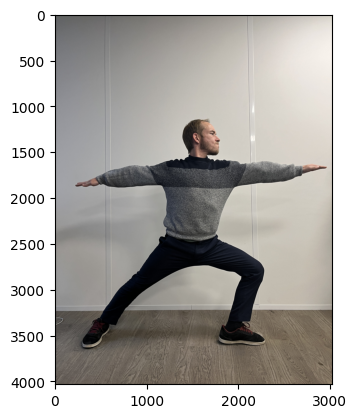



Predicted: 1 --> goddess
Actual: 4 --> warrior2
Filename: IMG_4891.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/warrior2/IMG_4891.JPG


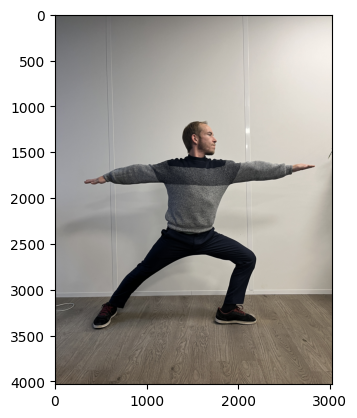



Predicted: 1 --> goddess
Actual: 0 --> downdog
Filename: IMG_4875.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/downdog/IMG_4875.JPG


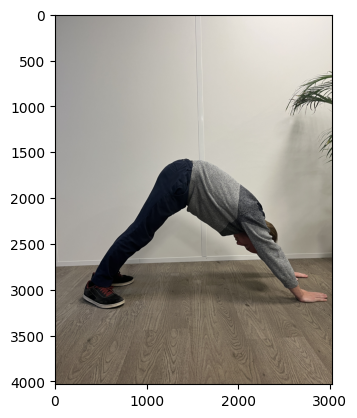



Predicted: 1 --> goddess
Actual: 0 --> downdog
Filename: IMG_4876.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/downdog/IMG_4876.JPG


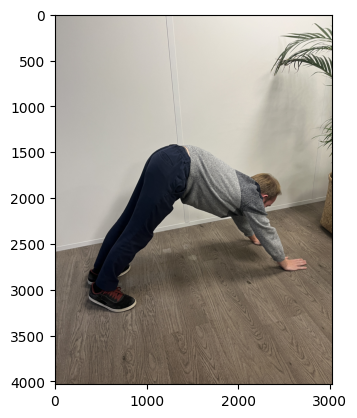



Predicted: 1 --> goddess
Actual: 0 --> downdog
Filename: IMG_4892.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/downdog/IMG_4892.JPG


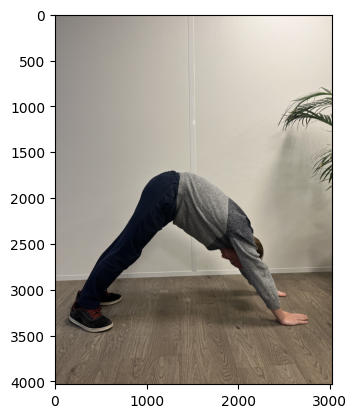



Predicted: 1 --> goddess
Actual: 3 --> tree
Filename: IMG_4888.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/tree/IMG_4888.JPG


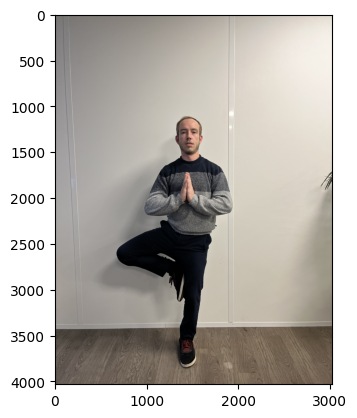



Predicted: 1 --> goddess
Actual: 3 --> tree
Filename: IMG_4889.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/tree/IMG_4889.JPG


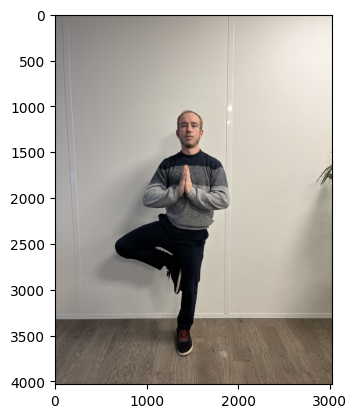



Predicted: 1 --> goddess
Actual: 1 --> goddess
Filename: IMG_4877.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/goddess/IMG_4877.JPG


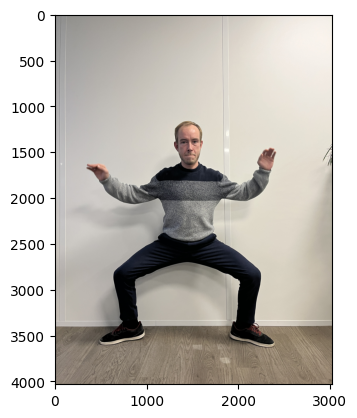



Predicted: 1 --> goddess
Actual: 1 --> goddess
Filename: IMG_4878.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/goddess/IMG_4878.JPG


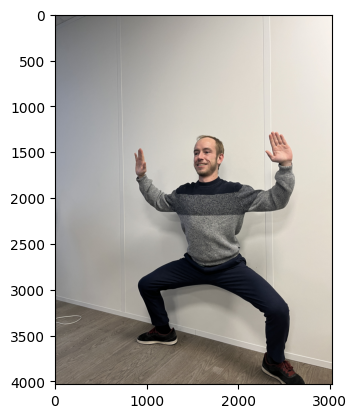



Predicted: 1 --> goddess
Actual: 1 --> goddess
Filename: IMG_4879.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/goddess/IMG_4879.JPG


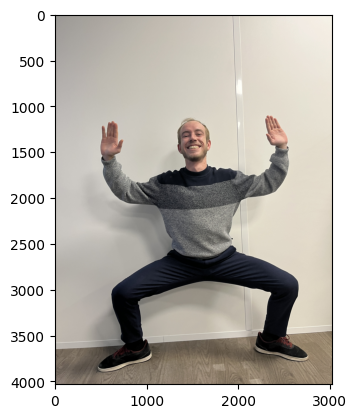



Predicted: 1 --> goddess
Actual: 1 --> goddess
Filename: IMG_4880.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/goddess/IMG_4880.JPG


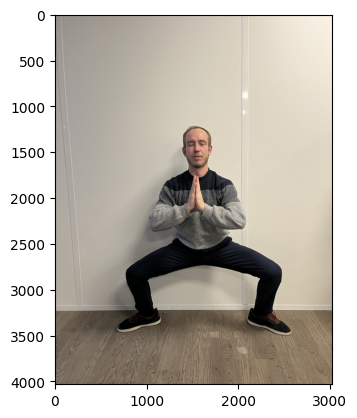



Predicted: 1 --> goddess
Actual: 1 --> goddess
Filename: IMG_4881.JPG
/Users/manulabricole/Documents/CDN/ACV/yoga_app/assets/images/validation/raw/goddess/IMG_4881.JPG


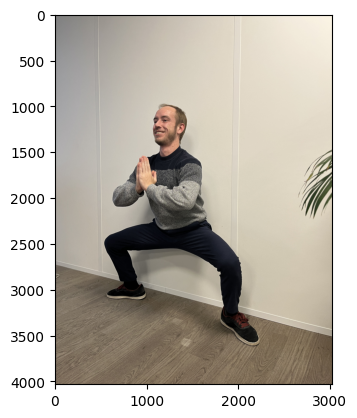

In [110]:
for _, actual in enumerate(y_val):
    print(f"Predicted: {pred} --> {num_to_class_dict[pred]}")
    print(f"Actual: {actual} --> {num_to_class_dict[actual]}")
    print(f"Filename: {filename.iloc[_]}")
    print_image_from_filename(filename.iloc[_])
    print("\n")